In [1]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import glob
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates, collections

from stompy import utils, memoize, filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils, xr_transect
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook
turbo=scmap.load_gradient('turbo.cpt')

In [2]:
#dem=field.GdalGrid("../../bathy/junction-composite-20190117-no_adcp.tif")
dem=field.GdalGrid("../../bathy/junction-composite-20200604-w_smooth.tif")

Load ADCP Data
==


In [3]:
# Load all of the averaged ADCP transects
# Extrapolate to bed/surface
# Add River Surveyor flow results
suffix='-avg_with_time.nc'
obs_tran_fns=glob.glob("../../field/adcp/040518_BT/*"+suffix)
obs_tran_fns.sort()
obs_trans=[]

# Load the flows as calculated by River Surveyor
rivr_Q=pd.read_csv('../../field/adcp/river_surveyor_flows-2018.csv')

# This offset is dialed in to get a match between measured flow
# and gauge flow.  Even though ADCP measured flow (as from python)
# does not include the sides, there is very little flow there, and
# without this offset, python values were almost identical to 
# river surveyor, and slightly better.
z_delta=-0.28

for fn in obs_tran_fns:
    print(fn)
    ds=xr.open_dataset(fn)
    # some transects, through the averaging process, have a sample
    # coordinate that is reversed. To reduce the risk of xarray getting
    # too clever, standardize the sample coordinate:
    ds['sample']=('sample',), np.arange(ds.dims['sample'])
    
    for v in ['z_bed','depth_m']:
        if 'positive' not in ds[v].attrs:
            ds[v].attrs['positive']='down'
            assert ds[v].mean()>0,"Maybe a bad assumption here"
    ds['eta']=(-z_delta) + 0*ds.depth_m
    ds.attrs['fn']=fn
    ds.attrs['label']=os.path.basename(fn).replace(suffix,'').replace('BTref','')
    # ASSUME ADCP is PDT. Have not been able to verify this.
    ds['time']=ds.time+np.timedelta64(7,'h')

    if 1:
        # A little cleanup
        # column with no bed elevation gets deleted
        ds=ds.isel(sample=np.isfinite(ds.z_bed.values))
        xr_transect.mask_bed(ds,ds.U,depth_fraction=0.75,z_top=ds.eta)

    # Strong secondary, particulary transect 7, make the surface power fit
    # not great.
    if ( ('040518_8' in fn) or
         ('040518_9' in fn) ):
        surf_method='constant'
    else:
        surf_method='pow(0.167)'
    print("  surface extrapolation: ",surf_method)

    bed_method='pow(0.167)'
    ds=xr_transect.extrapolate_vertical(ds,
                                        [ ('U',dict(xy=0),bed_method,surf_method),
                                          ('U',dict(xy=1),bed_method,surf_method)],
                                        eta=ds.eta.mean(),z_bed='z_bed',
                                        save_original=True)
    # Not sure where the bug is, but shift_vertical before the extrapolate call
    # does not work.
    xr_transect.shift_vertical(ds,z_delta)
    
    # Add River Surveyor Flows
    Qests=[]
    for idx,row in rivr_Q.iterrows():
        if row['filename'].startswith(ds.label):
            Qests.append(row['flow_m3s'])
    assert len(Qests)>0
    ds['Qmean']=(),np.mean(Qests)
    ds['Qstd']=(),np.std(Qests)
    ds['Qmedian']=(),np.median(Qests)
    obs_trans.append(ds)

../../field/adcp/040518_BT/040318_1_BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_2BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_3_BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_4BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_5BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_6BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_7_BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_8BTref-avg_with_time.nc
  surface extrapolation:  constant
../../field/adcp/040518_BT/040518_9BTref-avg_with_time.nc
  surface extrapolation:  constant


In [4]:
ls runs/

cfg011_farm12_20180310/  cfg012_farm12_20180409/  large13_20180320/
cfg011_farm12_20180320/  farm-test02_20180405/    large13_20180330/
cfg011_farm12_20180330/  farm-test03_20180405/    large13_20180409/
cfg012_farm12_20180310/  farm-test04_20180405/    largetest01_20180405/
cfg012_farm12_20180320/  farm-test05_20180405/
cfg012_farm12_20180330/  large13_20180310/


In [5]:
six.moves.reload_module(sun_driver)
models=[
#    sun_driver.SuntansModel.load("/opt2/san_joaquin/cfg008/cfg008_20180409"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/cfg007_20180330"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short037_20180405"),
    
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short039_20180402"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short039_20180402-nh"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short047.g8.50_20180402"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short049.g8.50_20180402"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short050.g8.50_20180405"),
     
    # DWR, aniso smooth, 4h, z0B=5e-3
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short051.g8.50_20180405"),
    
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short052.g8.50_20180405"),

    # DWR, aniso smooth, 4h, z0B=5e-2
    #sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short053.g8.50_20180405"),
    
    # DWR, aniso smooth, 4h, z0B=5e-3, grid7-45
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short054.g7.45_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-3, grid6
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short055.g6_20180405"),

    # DWR, aniso smooth 4h, z0B=5e-3, grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short056.g8.50_20180405"),
  
    # DWR, aniso smooth 4h, z0B=5e-3, grid8, MY2.5, +hor_adv
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short057.g8.50_20180405"),
  
    # DWR, aniso smooth 4h, z0B=5e-3, grid8, parabolic, double vertical res
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short058.g8.50_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-4, grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short059.g8.50_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-5, grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short060.g8.50_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-4, grid8, parabolic, CdW=0.2
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short061.g8.50_20180405"),

    # DWR, aniso smooth, 4h, z0B=Variable (5e-3), grid8, parabolic
    #sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short062.g8.50_20180405"),
    
    # DWR, aniso smooth, 4h, z0B=Variable (1/30), grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short063.g8.50_20180405"),

    # DWR, aniso smooth, 6d, z0B=Variable (1/30), grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short064.g8.50_20180402"),

    # DWR, aniso smooth, 4h, z0B=Variable(1/30), grid8.60 (NEW), parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short065.g8.60_20180405"),
    
    # composite smoothed (just mid chan), 4h, z0B=Variable(1/30), grid8.60, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short066.g8.60_20180405"),
    
    # composite smoothed+adcp, 4h, z0B=Variable(1/30), grid8.60, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short067.g8.60_20180405"),
    
    # composite smoothed+adcp, 6d, z0B=Variable(1/30), grid8.60, parabolic
    # This is the current best.
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short068.g8.60_20180402"),
    
    # composite smoothed+adcp2 (includes ADCP up SJ), 4h, z0B=Variable(1/30), grid8.60, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short069.g8.60_20180405"),
    
    # composite smoothed+adcp, 4h, z0B=Variable(1/30), grid8.r03, parabolic
    # double resolution grid
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short070.g8r.03_20180405"),
    
    # Production version of short068
    # sun_driver.SuntansModel.load("/opt2/san_joaquin/cfg010/cfg010_20180330"),
    
    sun_driver.SuntansModel.load("runs/cfg012_farm12_20180330")
]

for m in models:
    m.projection="EPSG:26910"    
    if len(models)>1:
        m.label=os.path.basename(m.run_dir)
    else:
        m.label='Model'

In [7]:
fig_dir=os.path.join(models[-1].run_dir,'figs-20210427')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [8]:
smooth_wx=15 # if you change this, update the swimspeed paper text.
smooth_wz=9  # ditto

def smooth_adcp(transect,smooth_wx=15,smooth_wz=9):
    transect=transect.copy()
    # Smooth the observations
    U=transect.U.values
    # use an odd winsize!
    if smooth_wx:
        U=filters.lowpass_fir(transect.U.values,winsize=smooth_wx,axis=0)
    if smooth_wz:
        U=filters.lowpass_fir(U,winsize=smooth_wz,axis=1)
    transect['U']=transect['U'].dims,U
    xr_transect.add_rozovski(transect,force_left=True)
    return transect

In [9]:
@memoize.memoize(lru=20,key_method='str')
def extract_to_match_obs(obs_tran,model,time=None,preserve_angle=False):
    """
    obs_tran: transect to match
    model: SunDriver instance to pull data from
    time: specify time, overriding observation time, for querying model
    preserve_angle: assume obs_tran already has roz_angle, and use the
     same angles to rotate model data.
    """
    chain_interval=(model.chain_stop() - model.chain_start())
    steady=chain_interval<np.timedelta64(1,'D')
    if steady:
        t=-1 # choose the last step
    else:
        t=obs_tran.time.values
        if time is not None:
            t=time
    
    print(f"Extracting transect for time {t}")
    transect=model.extract_transect(xy=np.c_[obs_tran.x_sample,obs_tran.y_sample],
                                    dx=5,time=t)
    
    dzmin_surf=float(model.config.get('dzmin_surface','0.25'))
    
    model.adjust_transect_for_dzmin_surface(transect,update_vars=['U','Ve','Vn'],
                                            dzmin_surf=dzmin_surf)
    bed_offset=np.nanmean( xr_transect.pos_up(transect,'dv')
                          - xr_transect.pos_up(obs_tran,'depth_m'))
    print("Bed offset is ",bed_offset)
    offset=np.nanmean(transect.eta.values)
    xr_transect.shift_vertical(transect,-offset)
    transect.attrs['z_shift']=-offset
    transect['depth_m']=transect['dv']
    transect.attrs['label']=model.label
    if preserve_angle:
        transect['roz_angle']=('sample',),obs_tran['roz_angle'].values
        xr_transect.add_rotated(transect,src='U',dst='Uroz',frame='roz',comp_names=['downstream','left'],
                                angle_field='roz_angle') 
    else:
        xr_transect.add_rozovski(transect)
    return transect

In [10]:
def print_flows(all_trans):
    # Report flows:
    for tran in all_trans:
        Q=xr_transect.Qleft(tran)
        print(f"{tran.label:20}: Q (xr_transect)={Q:.3f}")
        if 'Qmean' in tran:
            print(f"                      Q (river surveyor)={tran.Qmean.item():.3f}")
        print()

In [11]:
print("Figures will save to: %s"%fig_dir)

Figures will save to: runs/cfg012_farm12_20180330/figs-20210427


In [12]:
class FigU(object):
    labels=None
    show_flow=False
    z_slice=[-2,0]
    show_bed=False # draw line for bed for each panel
    show_obs_bed=True # show ADCP bed location on model panels
    show_surface=False
    u_cmap=turbo
    delta_cmap='coolwarm'
    outline_valid_obs=True
    outline_valid_model=True
    lateral_quiver=False
    plot_error=False 
    smooth_model=False # apply smooothing to the model output similar to ADCP smoothing
    smooth_average=True # apply smoothing to extracted velocity after extraction.
    u_clim=[0,1.2]
    err_clim=[-0.2,0.2]
    figsize=(9,9)
    plot_averages=True # include a panel summarizing averages.
    z_as_depth=True # Change labels to reflect depth instead of elevation.
    
    axs=None # will create by default, or a list of Axes equal to 1+len(models), and 1 more
    # if plot_averages is True
    cax=None # colorbar axes for velocity 
    cax_err=None # colorbar axes for velocity error (if plot_error)
    gs=None # probably don't use this.
    fig=None
    
    def __init__(self,obs_tran,**kw):
        self.obs_tran=obs_tran
        utils.set_keywords(self,kw)
        self.fig=self.fig_uroz()
        
    def plot_uroz(self,tran,ax):
        val=tran.Uroz.sel(roz='downstream')
        if self.plot_error and (tran is not self.all_trans[0]):
            ref=self.all_trans[0].Uroz.sel(roz='downstream')
            val=val-ref
            coll=xr_transect.plot_scalar(tran,val,ax=ax,
                                         cmap=self.delta_cmap,
                                         clim=self.err_clim)
            cset=xr_transect.contour(tran,val,np.linspace(-0.5,0.5,11),
                                     ax=ax,colors='k',linewidths=0.5,)
        else:
            coll=xr_transect.plot_scalar(tran,val,ax=ax,
                                         cmap=self.u_cmap,
                                         clim=self.u_clim)
        if self.show_surface:
            ax.plot(tran.d_sample, tran.eta,'k--',label='surface')
        if self.show_bed:
            ax.plot(tran.d_sample,-tran.depth_m,'k-',label='bed')
        return coll

    def create_axes(self):
        n_trans=1+len(models) # observations and 1 or more models
        n_ax=n_trans
        if self.plot_averages:
            n_ax+=1
            
        self.gs=gs=gridspec.GridSpec(n_ax,2,width_ratios=[20,1])
        self.fig=fig=plt.figure(figsize=self.figsize)
        axs=[]
        for i in range(n_trans):
            if i==0:
                axs.append( fig.add_subplot(gs[i,:-1]))
            else:
                axs.append( fig.add_subplot(gs[i,:-1],
                                            sharex=axs[0],sharey=axs[0]))
        if self.plot_averages:
            self.ax_avg=fig.add_subplot(gs[-1,:-1],sharex=axs[0])
        self.axs=axs
                
        if not self.plot_error:
            self.cax=fig.add_subplot(gs[:-1,-1])
        else:
            nrows=len(self.all_trans)//2
            self.cax=fig.add_subplot(gs[:nrows,-1])
            self.cax_err=fig.add_subplot(gs[nrows:2*nrows,-1])

    def fig_uroz(self):
        obs_tran=smooth_adcp(self.obs_tran)
        mod_trans=[extract_to_match_obs(obs_tran,model,preserve_angle=True)
                   for model in models]
        
        if self.plot_error or self.smooth_model:
            # A bit of a hack -- assumes that the model is positive up
            # and the ADCP positive down.
            new_z=obs_tran.z_ctr.values
            new_mod_trans=[]
            for t in mod_trans: 
                t=xr_transect.resample_z(t,new_z,new_z_positive='down')
                # Smooth the model in the same way as the ADCP
                Uroz=t.Uroz.values
                Uroz=filters.lowpass_fir(Uroz,winsize=smooth_wx,axis=0)
                Uroz=filters.lowpass_fir(Uroz,winsize=smooth_wz,axis=1)
                t['Uroz']=t['Uroz'].dims,Uroz
                new_mod_trans.append(t)
            mod_trans=new_mod_trans
                
        all_trans=[obs_tran]+mod_trans
        self.all_trans=all_trans
        
        # goofy logic to allow appending extra models without worrying about
        # adjusting names passed in.
        labels=self.labels
        if labels is None:
            labels=[]
        for i,t in enumerate(all_trans):
            if i>=len(labels):
                labels.append(t.attrs.get('label',str(i)))

        if self.axs is None:
            self.create_axes()
        axs=self.axs
        
        colls=[]

        for tran,ax,label in zip(all_trans,axs,labels):
            coll=self.plot_uroz(tran,ax) # including error plotting
            colls.append(coll)
            ax.text(0.02,0.04,label,transform=ax.transAxes)
            if self.show_obs_bed and (tran is not obs_tran):
                ax.plot(obs_tran.d_sample,-obs_tran.depth_m,'0.5',label='Obs. bed')
            if self.lateral_quiver:
                self.add_quiver(tran,ax)
            if self.show_flow: 
                Q=xr_transect.Qleft(tran)
                ax.text(0.5,0.02,f"Q={Q:.2f} m$^3$/s",transform=ax.transAxes,
                       va='bottom')
            if self.z_as_depth:
                ax.set_ylabel('Depth (m)')
            else:
                ax.set_ylabel('z (m)')
                
            if self.gs is not None: # having trouble getting xticks when I pass in axs.
                plt.setp(ax.get_xticklabels(),visible=0)
        if self.outline_valid_obs: # outline the valid ADCP data
            t=obs_tran
            ax=axs[0]
            xr_transect.contour(t,np.isfinite(t.U_nofill.isel(xy=0)),[0.9],ax=ax,
                                colors='k',linewidths=0.5,linestyles='dashed')
            
        if self.outline_valid_model:
            for t,ax in zip(all_trans[1:],axs[1:]):
                xr_transect.contour(t,np.isfinite(t.U.isel(xy=0)),[0.9],ax=ax,
                                    colors='k',linewidths=0.5,linestyles='dashed')

        if self.plot_averages:
            axl=self.ax_avg

            for tran,label in zip(all_trans,labels):
                new_z=np.linspace(self.z_slice[0],self.z_slice[1],20)
                tran_slice=xr_transect.resample_z(tran,new_z,new_z_positive='up')
                Uslice=xr_transect.depth_avg(tran_slice,'Uroz')
                u=Uslice.sel(roz='downstream').values
                if self.smooth_average and (tran is not all_trans[0]):
                    u=filters.lowpass_fir(u,winsize=smooth_wx,axis=0)
                axl.plot(tran_slice.d_sample,u,label=label)
            axl.legend(loc='upper left',bbox_to_anchor=(1.02,1),frameon=0)
            axl.set_xlabel('Distance (m)')
            axl.set_ylabel('Velocity (m s$^{-1}$)')
            ymin=axl.get_ylim()[0]
            axl.axis(ymin=min(ymin,0))
            
        if self.z_as_depth:
            for ax in axs:
                yticks=ax.get_yticks() 
                # goofy +0 to get -0 => 0
                ax.set_yticklabels(["%.1f"%(-d+0.0) for d in yticks])
    
        plt.colorbar(colls[0],cax=self.cax,label='m s$^{-1}$')
        if self.plot_error:
            plt.colorbar(colls[1],cax=self.cax_err,label='m s$^{-1}$')
        if self.fig is not None:
            self.fig.subplots_adjust(wspace=0.07,right=0.85,top=0.97,left=0.11)
        return self.fig
    
    def add_quiver(self,tran,ax):
        x_stride=tran.dims['sample']//20
        dz=np.abs(np.nanmedian(tran.z_ctr.diff(dim='layer').values))
        z_stride=int(0.75/dz)
        t_sparse=tran.isel(sample=slice(None,None,x_stride),
                           layer=slice(None,None,z_stride))
        if 'U_nofill' in t_sparse:
            V,X,Z,Vorig = xr.broadcast(t_sparse.Uroz.isel(roz=1),
                                       t_sparse.d_sample,xr_transect.pos_up(t_sparse,'z_ctr'),
                                       t_sparse.U_nofill.isel(xy=0))
            # complicated by the fact that the extrapolation can't deal with
            # secondary flow, so lateral shows up as zero.
            valid=np.isfinite(Vorig.values)
        else:
            V,X,Z = xr.broadcast(t_sparse.Uroz.isel(roz=1),
                                 t_sparse.d_sample,xr_transect.pos_up(t_sparse,'z_ctr'))
            valid=slice(None)
        qset=ax.quiver(X.values[valid],Z.values[valid],
                       -V.values[valid],0*V.values[valid],
                       angles='xy',scale_units='width',scale=2,units='width',
                       width=0.002,pivot='mid',)
        ax.quiverkey(qset,0.9,0.05,0.1,'0.1 m s$^{-1}$',coordinates='axes')

In [13]:
obs_trans[0]

<xarray.Dataset>
Dimensions:           (beam: 4, layer: 215, sample: 211, xy: 2)
Coordinates:
  * sample            (sample) int64 0 1 2 3 4 5 6 ... 205 206 207 208 209 210
  * beam              (beam) int64 0 1 2 3
  * xy                (xy) int64 0 1
Dimensions without coordinates: layer
Data variables:
    z_ctr             (layer) float64 -1.11e-16 0.02766 0.05531 ... 5.891 5.918
    z_dz              (layer) float64 0.02766 0.02766 ... 0.02766 0.02766
    x_sample          (sample) float64 ...
    y_sample          (sample) float64 ...
    d_sample          (sample) float64 ...
    frequency         (sample) float64 ...
    depth_m           (sample) float64 0.86 0.86 0.88 0.88 ... 0.88 0.88 0.88
    snr               (sample, layer, beam) float64 nan nan nan ... nan nan nan
    cell_start        (sample) float64 ...
    cell_size         (sample) float64 ...
    Ve                (sample, layer) float64 nan nan nan nan ... nan nan nan
    Vn                (sample, layer) float64

<IPython.core.display.Javascript object>


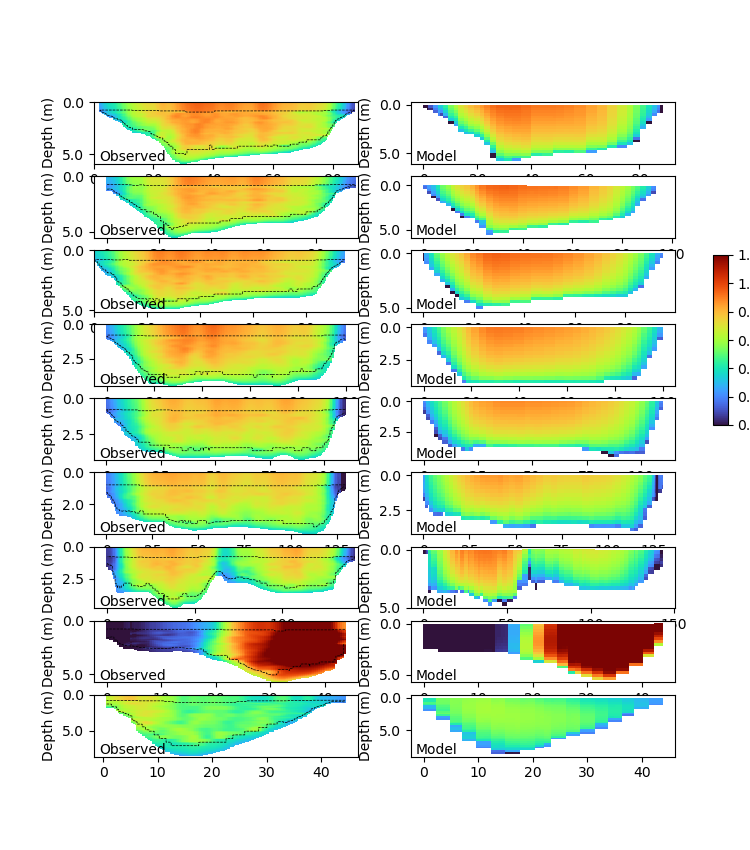

Extracting transect for time 2018-04-03T20:29:48.500000000
Bed offset is  -1.6060740173775672
Extracting transect for time 2018-04-04T15:49:52.500000000
Bed offset is  -1.4178463327200632
Extracting transect for time 2018-04-05T18:03:34.000000000
Bed offset is  -1.532248855855856
Extracting transect for time 2018-04-05T18:29:30.500000000
Bed offset is  -1.4936476215053762
Extracting transect for time 2018-04-05T19:00:24.000000000
Bed offset is  -1.53487383625731
Extracting transect for time 2018-04-05T19:34:19.500000000
Bed offset is  -1.5447055871271584
Extracting transect for time 2018-04-05T20:06:22.500000000
Bed offset is  -1.6293043037383177
Extracting transect for time 2018-04-05T20:37:19.500000000
Bed offset is  -1.4776428320413435
Extracting transect for time 2018-04-05T21:12:15.000000000
Bed offset is  -1.7773451958797701


In [14]:
# One figure with a panel for each transect
fig,axs=plt.subplots(9, 2, figsize=(7.5,8.5))
cax=fig.add_axes([0.95,0.5,0.02,0.2])

for ax_pair,t in zip(axs,obs_trans):
    cax.cla()
    F=FigU(t,labels=['Observed'],z_slice=[-2,0],lateral_quiver=False,plot_error=False,show_obs_bed=False,
           outline_valid_model=False,smooth_model=False,smooth_average=True,plot_averages=False,
           cax=cax,axs=ax_pair)
    # Save model-extracted transect:
    obs_tran,mod_tran=F.all_trans[:2]
    
    mod_tran.to_netcdf(os.path.join(fig_dir,obs_tran.attrs['label']+"_model.nc"))

<IPython.core.display.Javascript object>


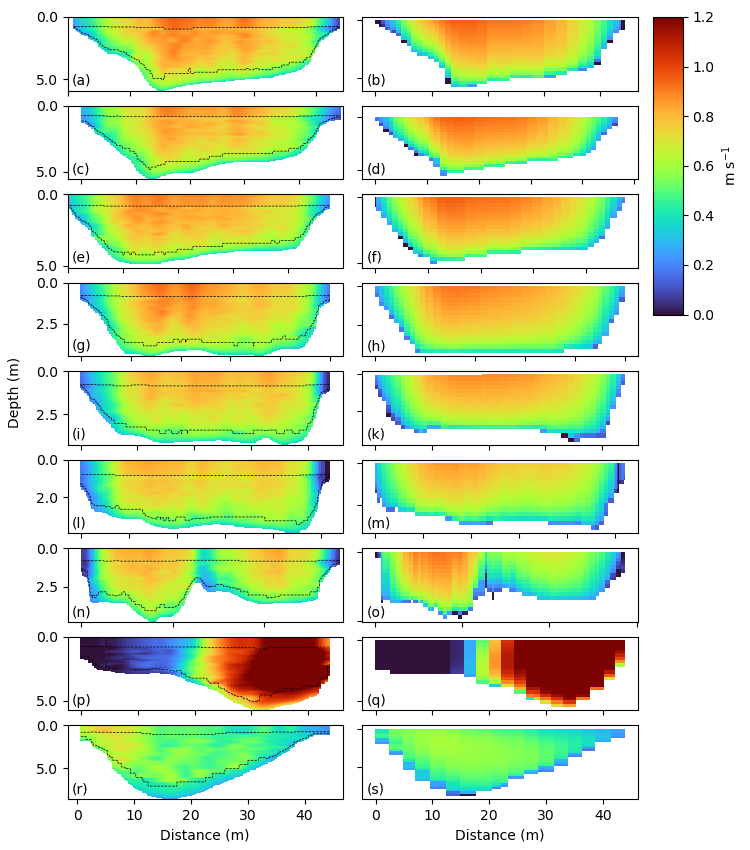

Extracting transect for time 2018-04-03T20:29:48.500000000
Bed offset is  -1.6060740173775672
Extracting transect for time 2018-04-04T15:49:52.500000000
Bed offset is  -1.4178463327200632
Extracting transect for time 2018-04-05T18:03:34.000000000
Bed offset is  -1.532248855855856
Extracting transect for time 2018-04-05T18:29:30.500000000
Bed offset is  -1.4936476215053762
Extracting transect for time 2018-04-05T19:00:24.000000000
Bed offset is  -1.53487383625731
Extracting transect for time 2018-04-05T19:34:19.500000000
Bed offset is  -1.5447055871271584
Extracting transect for time 2018-04-05T20:06:22.500000000
Bed offset is  -1.6293043037383177
Extracting transect for time 2018-04-05T20:37:19.500000000
Bed offset is  -1.4776428320413435
Extracting transect for time 2018-04-05T21:12:15.000000000
Bed offset is  -1.7773451958797701


In [13]:
for ax in axs[:,1]:
    plt.setp(ax.get_yticklabels(),visible=0)
    ax.set_ylabel('')

fig.subplots_adjust(bottom=0.06,left=0.09,top=0.98,wspace=0.07,right=0.85)

cax.set_position([0.87,0.63,0.04,0.35])

for ax in axs[:-1,:].ravel():
    plt.setp(ax.get_xticklabels(),visible=0)
for ax in axs[-1,:]:
    ax.set_xlabel('Distance (m)')
    
# Letter the panels:
panels="abcdefghiklmnopqrstuvwxyz"
for ax_i,ax in enumerate(axs.ravel()):
    ax.texts=[] # Drop the Observed, Model texts
    ax.text(0.015,0.08,"(%s)"%panels[ax_i],
           transform=ax.transAxes)
    
# Show as depth rather than elevation
for ax in axs[:,0]:
    ax.set_ylabel('') 
    
fig.texts=[]
fig.text(0.01,0.5,'Depth (m)',rotation=90)
fig.savefig(os.path.join(fig_dir,'tran-all-slice_with_top2m.png'),dpi=200)

<IPython.core.display.Javascript object>


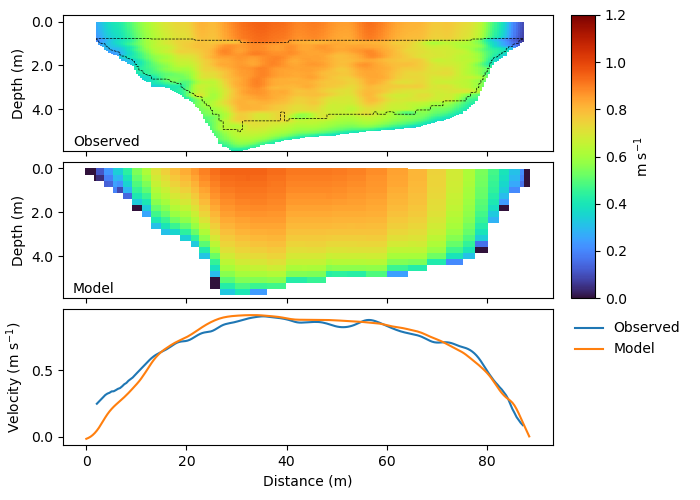

<IPython.core.display.Javascript object>


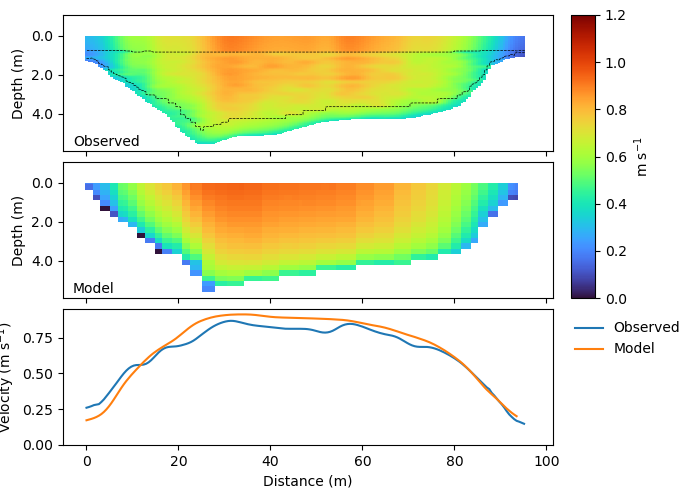

<IPython.core.display.Javascript object>


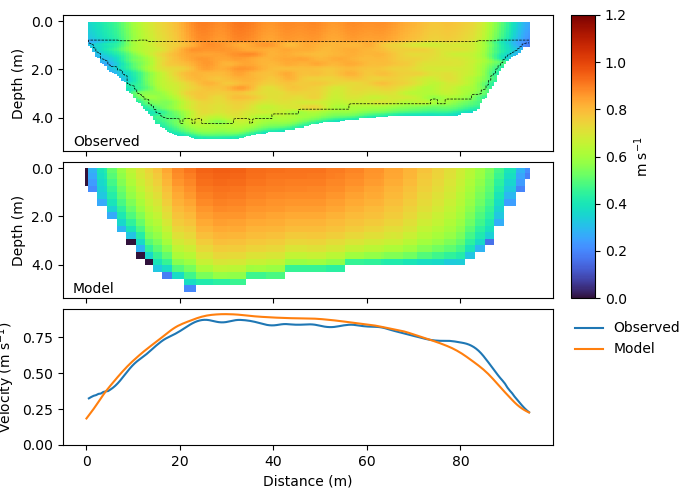

<IPython.core.display.Javascript object>


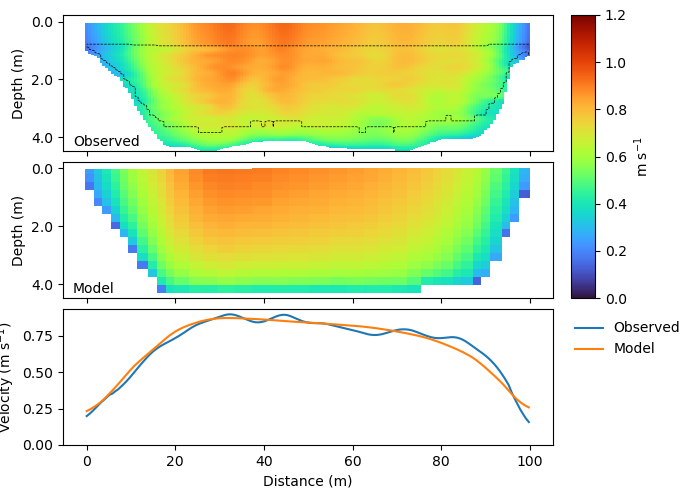

<IPython.core.display.Javascript object>


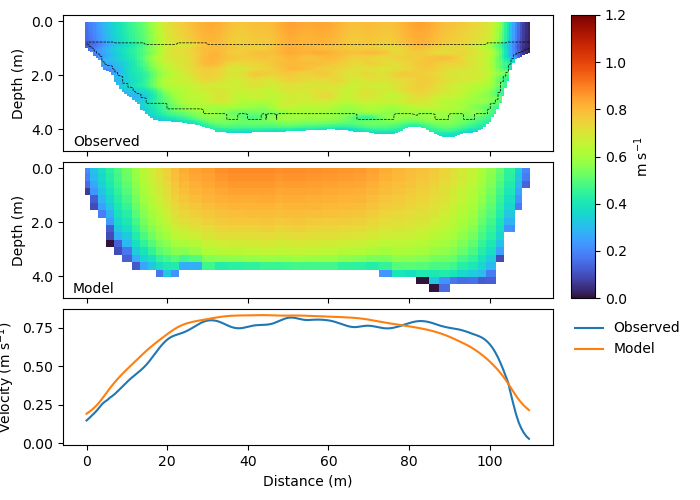

<IPython.core.display.Javascript object>


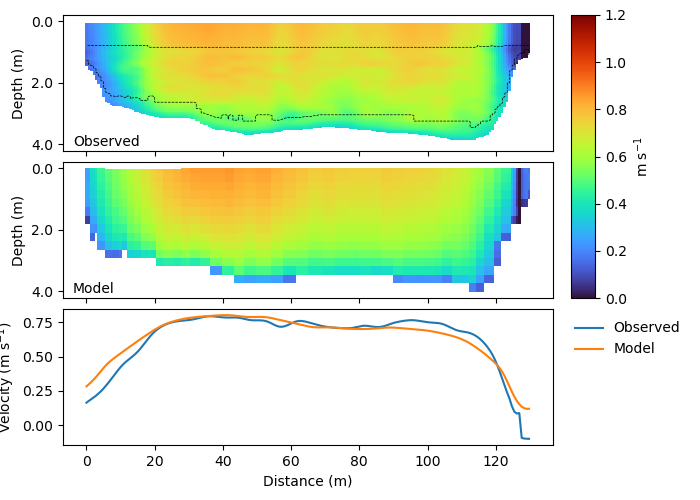

<IPython.core.display.Javascript object>


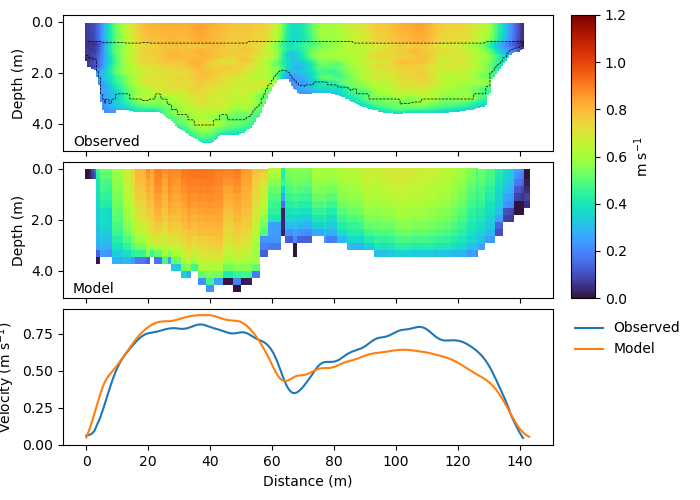

<IPython.core.display.Javascript object>


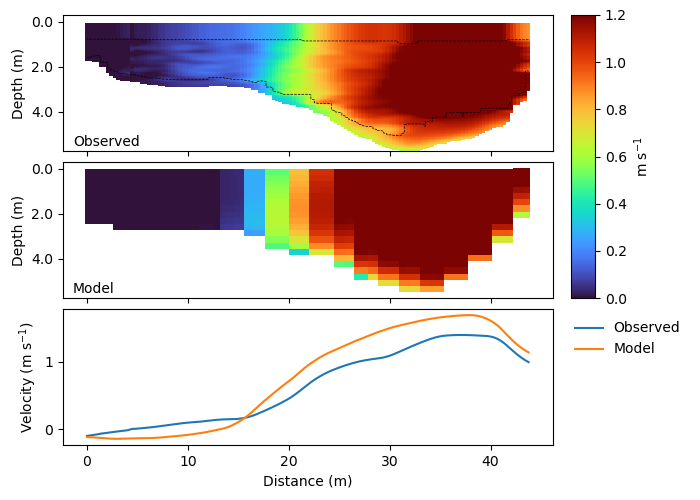

<IPython.core.display.Javascript object>


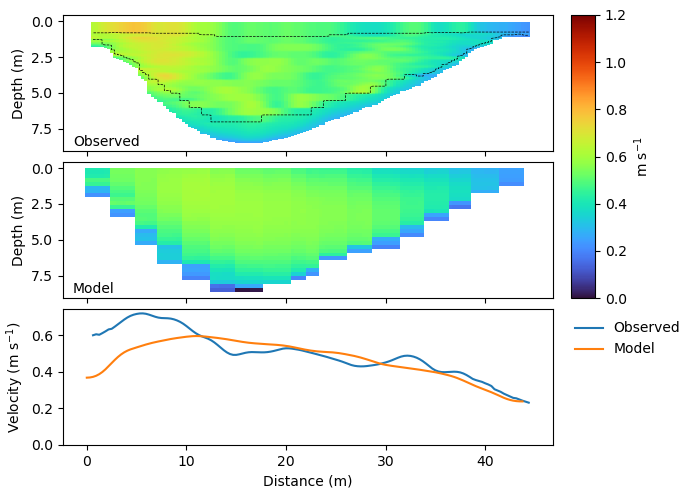

In [14]:
# For presentation:
for t in obs_trans:
    F=FigU(t,labels=['Observed'],z_slice=[-2,0],lateral_quiver=False,plot_error=False,show_obs_bed=False,
           outline_valid_model=False,smooth_model=False,smooth_average=True,
           figsize=(7,5))
    F.fig.subplots_adjust(left=0.09,hspace=0.08)
    F.fig.savefig(os.path.join(fig_dir,'tran-%s-slice_with_top2m.png'%t.label),dpi=200)

<IPython.core.display.Javascript object>


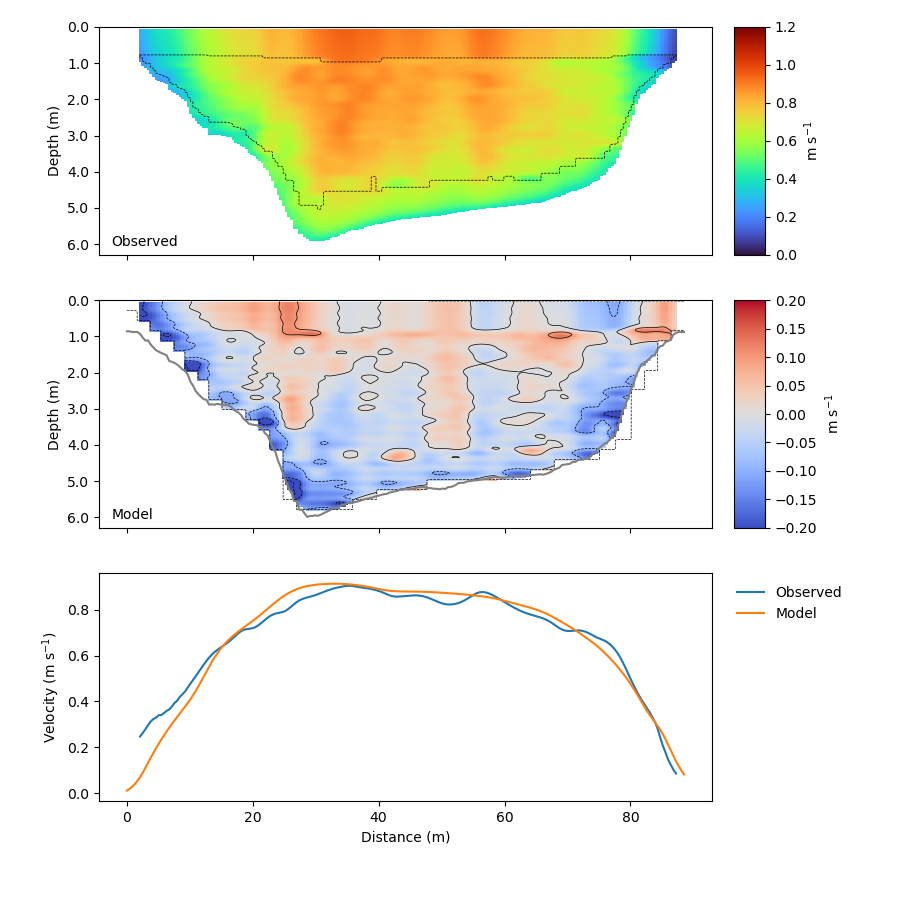

In [15]:
# For diagnostics:
for t in obs_trans:
    F=FigU(t,labels=['Observed'],z_slice=[-2,0],lateral_quiver=False,plot_error=True)
    break

Skill, Metrics, Target Diagrams
==

In [16]:
def prep_for_comparison(obs_tran,models,z_slice,rotate=True,
                        return_datasets=False):
    """
    extract matching transects, smooth observations,
    average over all or part of the water column, return just the
    matched up arrays of velocity.
    rotate: when True, rotate each transect to Rozovski angle from
        observation.
    return_datasets: if True, copy and return the whole dataset,
     with a 'Uavg' field. If False, just return the average data.
    """
    obs_tran=smooth_adcp(obs_tran)
    mod_trans=[extract_to_match_obs(obs_tran,model)
               for model in models]
    trans=[obs_tran] + mod_trans

    # Resample each vertically to just the slice we care about
    if z_slice is not None:
        new_z=np.linspace(z_slice[0],z_slice[1],20)
        trans=[xr_transect.resample_z(tran,new_z,new_z_positive='up')
               for tran in trans]
    # As needed, get on a common lateral coordinate:
    resample_x=False
    for t in trans[1:]:
        if not (np.allclose(trans[0].x_sample.values, 
                            t.x_sample.values)
               and
               np.allclose(trans[0].y_sample.values,
                          t.y_sample.values) ):
            resample_x=True
            break
    if resample_x:
        print("Whoa - why are we resampling?")
        trans=xr_transect.resample_to_common(trans,resample_z=False,save_original=None)
        
    if rotate:
        # Rotate model transects to match ADCP rozovski
        for t in mod_trans:
            t['roz_angle']=('sample',),obs_tran.roz_angle
            xr_transect.add_rotated(t,src='U',dst='Uroz',frame='roz',comp_names=['downstream','left'],
                                    angle_field='roz_angle')    

        # Now use rotated, so biases can be more meaningful
        depth_averages=[ xr_transect.depth_avg(t,'Uroz') for t in trans]
    else:
        depth_averages=[ xr_transect.depth_avg(t,'U') for t in trans]
    if not return_datasets:
        return depth_averages
    else:
        results=[]
        for t,avg in zip(trans,depth_averages):
            t=t.copy()
            t['Uavg']=avg
            results.append(t)
        return results

In [17]:
ds=xr.Dataset()

tran_names=[t.label for t in obs_trans]

ds['transect_label']=('transect',),tran_names

In [18]:
# define vertical slices
ds['slice']=('slice',), ['top1m','top2m','full_depth']
ds['slice_nice']=('slice',), ['Top 1m','Top 2m','Full Depth']
ds['slice_defs']=('slice',), [ (-1,0), (-2,0), None]

In [19]:
ds['models']=('model',), [m.label for m in models]

In [20]:
ds['obs_avg']=('transect','slice'), np.zeros( (ds.dims['transect'],
                                               ds.dims['slice']), object)
ds['mod_avg']=('transect','slice','model'), np.zeros( (ds.dims['transect'],
                                                       ds.dims['slice'],
                                                       ds.dims['model']), object)

In [21]:
for obs_i,obs_tran in enumerate(obs_trans):
    print("Transect",obs_i)
    for sl_i,sl in enumerate(ds.slice_defs.values):
        print(f'  Slice {sl}')
        depth_averages = prep_for_comparison(obs_tran,models,z_slice=sl)
        ds['obs_avg'].values[obs_i,sl_i]=depth_averages[0]
        for mod_i,mod_avg in enumerate(depth_averages[1:]):
            ds['mod_avg'].values[obs_i,sl_i,mod_i]=mod_avg

Transect 0
  Slice (-1, 0)
Extracting transect for time 2018-04-03T20:29:48.500000000
Bed offset is  -1.6060740173775672
  Slice (-2, 0)
  Slice None
Transect 1
  Slice (-1, 0)
Extracting transect for time 2018-04-04T15:49:52.500000000
Bed offset is  -1.4178463327200632
  Slice (-2, 0)
  Slice None
Transect 2
  Slice (-1, 0)
Extracting transect for time 2018-04-05T18:03:34.000000000
Bed offset is  -1.532248855855856
  Slice (-2, 0)
  Slice None
Transect 3
  Slice (-1, 0)
Extracting transect for time 2018-04-05T18:29:30.500000000
Bed offset is  -1.4936476215053762
  Slice (-2, 0)
  Slice None
Transect 4
  Slice (-1, 0)
Extracting transect for time 2018-04-05T19:00:24.000000000
Bed offset is  -1.53487383625731
  Slice (-2, 0)
  Slice None
Transect 5
  Slice (-1, 0)
Extracting transect for time 2018-04-05T19:34:19.500000000
Bed offset is  -1.5447055871271584
  Slice (-2, 0)
  Slice None
Transect 6
  Slice (-1, 0)
Extracting transect for time 2018-04-05T20:06:22.500000000
Bed offset is  -1

In [22]:
# Add metrics
ds['obs_std']=('transect','slice'),np.zeros((ds.dims['transect'],ds.dims['slice']),np.float64)
for f in ['rmse','mae',
          'ub_rmse','ub_rmse_u','ub_rmse_v',
          'bias_u','bias_v','mod_std']:
    ds[f]=('transect','slice','model'), np.zeros((ds.dims['transect'],ds.dims['slice'],ds.dims['model']))

all_obs_u=[]

for t_i,t in enumerate(ds.transect):
    for sl_i,sl in enumerate(ds.slice):
        obs_avg=ds.obs_avg.isel(transect=t_i,slice=sl_i).item()
        all_obs_u.append(obs_avg.values)
        
        ubar=obs_avg.mean(dim='sample')
        obs_std=np.sqrt(np.nanmean( (obs_avg.values-ubar.values)**2))
        ds.obs_std.values[t_i,sl_i]=obs_std
        
        for m_i,model in enumerate(ds.model):
            sel_kw=dict(transect=t_i,slice=sl_i,model=m_i)
            mod_avg=ds.mod_avg.isel(sel_kw).item()
            
            err=mod_avg.values-obs_avg.values
            err_mag=utils.mag(err)

            err_mean=np.nanmean(err,axis=0)
            uberr=mod_avg.values-err_mean-obs_avg.values
            uberr_mag=utils.mag(uberr)
            ds['rmse'].isel(sel_kw).values[...]=np.sqrt(np.nanmean(err_mag**2))
            ds['ub_rmse'].isel(sel_kw).values[...]=np.sqrt(np.nanmean(uberr_mag**2))
            # I want to also report error just in the long/lat components:
            ds['ub_rmse_u'].isel(sel_kw).values[...]=np.sqrt(np.nanmean(uberr[:,0]**2))
            ds['ub_rmse_v'].isel(sel_kw).values[...]=np.sqrt(np.nanmean(uberr[:,1]**2))            
            ds['mae'].isel(sel_kw).values[...]=np.nanmean(err_mag)
            ds['bias_u'].isel(sel_kw).values[...]=err_mean[0]
            ds['bias_v'].isel(sel_kw).values[...]=err_mean[1]
            
            # This would be better done as proper Q/A, not average
            # over depth-averages.
            mod_ubar=mod_avg.mean(dim='sample')
            mod_std=np.sqrt(np.nanmean( (mod_avg.values-mod_ubar.values)**2 ))
            ds['mod_std'].isel(sel_kw).values[...]=mod_std            

In [23]:
# For each slice, calculate standard deviation of velocities across
# all observed transects
slice_stds=[]

for sl_i,sl in enumerate(ds.slice):
    all_obs_u=[ ds.obs_avg.isel(transect=t_i,slice=sl_i).item().values
                for t_i,t in enumerate(ds.transect) ]
    all_obs_u=np.concatenate(all_obs_u,axis=0)
    all_ubar=np.nanmean(all_obs_u,axis=0)

    all_std=np.sqrt(np.nanmean( (all_obs_u - all_ubar)**2))
    slice_stds.append(all_std)
    
ds['global_std']=('slice',),slice_stds

In [24]:
signs=1-2*(ds['mod_std']<ds['obs_std'])
ds['ubs_rmse']=signs*ds['ub_rmse']

In [25]:
stats_fn='model-slice-comparisons-20200827.pkl'

In [26]:
with open(stats_fn,'wb') as fp:
    pickle.dump(ds,fp,protocol=-1)

In [27]:
with open(stats_fn,'rb') as fp:
    ds=pickle.load(fp)

In [28]:
ds_metrics=ds.copy()
del ds_metrics['obs_avg']
del ds_metrics['mod_avg']

In [29]:
df=ds_metrics.isel(slice=0).to_dataframe()
df

transect_label  slice slice_nice slice_defs models   obs_std  \
model transect                                                                
0     0             040318_1_  top1m     Top 1m    (-1, 0)  Model  0.144617   
      1              040518_2  top1m     Top 1m    (-1, 0)  Model  0.140877   
      2             040518_3_  top1m     Top 1m    (-1, 0)  Model  0.123136   
      3              040518_4  top1m     Top 1m    (-1, 0)  Model  0.138774   
      4              040518_5  top1m     Top 1m    (-1, 0)  Model  0.144116   
      5              040518_6  top1m     Top 1m    (-1, 0)  Model  0.150696   
      6             040518_7_  top1m     Top 1m    (-1, 0)  Model  0.141914   
      7              040518_8  top1m     Top 1m    (-1, 0)  Model  0.373549   
      8              040518_9  top1m     Top 1m    (-1, 0)  Model  0.100254   

                    rmse       mae   ub_rmse  ub_rmse_u  ub_rmse_v    bias_u  \
model transect                                                                 
0     0         0.064654  0.050493  0.063117   0.062409   0.009428  0.009040   
      1         0.068231  0.058892  0.052970   0.052230   0.008825  0.042598   
      2         0.052666  0.045923  0.050156   0.049843   0.005597  0.015461   
      3         0.041018  0.034104  0.039696   0.039506   0.003877  0.009463   
      4         0.073624  0.065783  0.063003   0.062373   0.008885  0.037588   
      5         0.097474  0.062947  0.091465   0.090693   0.011856  0.033503   
      6         0.111600  0.098881  0.111184   0.103103   0.041613  0.009600   
      7         0.277647  0.246871  0.168994   0.161195   0.050747  0.218337   
      8         0.120736  0.098842  0.099902   0.084914   0.052631 -0.041486   

                  bias_v   mod_std  global_std  ubs_rmse  
model transect                                            
0     0         0.010707  0.180623    0.175753  0.063117  
      1         0.005920  0.159945    0.175753  0.052970  
      2        -0.004360  0.145435    0.175753  0.050156  
      3        -0.004145  0.135707    0.175753 -0.039696  
      4        -0.006186  0.131631    0.175753 -0.063003  
      5        -0.003588  0.102066    0.175753 -0.091465  
      6        -0.000724  0.129983    0.175753 -0.111184  
      7         0.029285  0.463883    0.175753  0.168994  
      8         0.053624  0.075355    0.175753 -0.099902

<IPython.core.display.Javascript object>


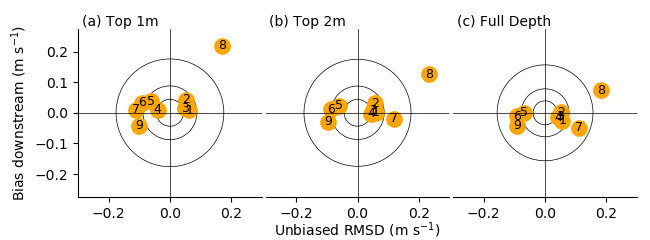

In [30]:
# Try some target-diagram-ish plots:
from matplotlib.patches import Circle

xmax=0.3

for m_i in range(ds_metrics.dims['model']):
    fig,axs=plt.subplots(1,ds_metrics.dims['slice'],figsize=(6.5,2.4))

    for sl,ax in enumerate(axs):
        sub_ds=ds_metrics.isel(slice=sl,model=m_i)
        df=sub_ds.to_dataframe()

        t_x=df.ubs_rmse
        t_y=df.bias_u
        ax.plot(t_x,t_y,'o',color='orange',ms=11)

        for t_i,(x,y) in enumerate(zip(t_x,t_y)):
            if x>xmax:
                ax.text(xmax,y,r"%d$\rightarrow$"%(t_i+1),ha='right',va='center')
            elif x<-xmax:
                ax.text(-xmax,y,r"$\leftarrow$%d"%(t_i+1),ha='left',va='center')
            else:
                ax.text(x,y,"%d"%(t_i+1),ha='center',va='center',fontsize=9)

        ax.axhline(0,color='k',lw=0.5)
        ax.axvline(0,color='k',lw=0.5)
        ax.set_ylabel('Bias downstream (m s$^{-1}$)')
        ax.axis('equal')

        for r in np.array([0.25,0.5,1.0]) * sub_ds.global_std.item():
            circ=Circle([0,0],r,ec='k',fc='none',lw=0.5)
            ax.add_patch(circ)
        ax.axis(xmin=-xmax,xmax=xmax,ymin=-xmax,ymax=xmax)

        # Make an axes label like '(a) Top 1m'
        ax_lbl=f"({'abcdef'[sl]}) {sub_ds['slice_nice'].item()}"
        ax.text(0.02,1.0,ax_lbl,transform=ax.transAxes,va='bottom')

    for ax in axs[1:]:
        plt.setp(ax.get_yticklabels(),visible=0)
        plt.setp(ax.yaxis.label,visible=0)
        plt.setp(ax.xaxis.label,visible=0)

    fig.subplots_adjust(top=0.88,left=0.12,right=0.98,bottom=0.18,wspace=0.02)
    # Share the x-axis label
    xlab='Unbiased RMSD (m s$^{-1}$)'

    xmid=0.5*( axs[0].get_position().xmin + axs[-1].get_position().xmax)
    fig.text(xmid,0.02,xlab,ha='center')

    for ax in axs:
        ax.spines['top'].set_visible(0)
        ax.spines['right'].set_visible(0)
    for ax in axs[1:]:
        ax.spines['left'].set_visible(0)
        ax.yaxis.set_visible(0)
    
    if 1:
        fig.savefig(os.path.join(fig_dir,'target-diagram.png'),dpi=200)


In [31]:
# Same thing, but as a table:
import os
os.environ['NUMEXPR_MAX_THREADS']="1"

for m_i in range(ds_metrics.dims['model']):
    sub_ds=ds_metrics.isel(model=m_i)
    sub_ds['slice']=sub_ds.slice_nice
    sub_ds=sub_ds.rename({'ub_rmse':'URMSD',
                          'ub_rmse_v':'URMSD (v)',
                          'bias_u':'BIAS (u)',
                          'transect':'Transect',
                          'slice':'Slice'})
    df=sub_ds.to_dataframe()
    df=df.loc[:,['URMSD','URMSD (v)','BIAS (u)']]
    df=df.unstack('Slice')
    df=df.set_index(df.index+1)

    pd.set_option('display.float_format',lambda f: "%.3f"%f)
    pd.set_option('precision',3) 
    display(df)
    
None

URMSD                URMSD (v)                 BIAS (u)         \
Slice    Full Depth Top 1m Top 2m Full Depth Top 1m Top 2m Full Depth Top 1m   
Transect                                                                       
1             0.056  0.063  0.060      0.016  0.009  0.019     -0.026  0.009   
2             0.051  0.053  0.057      0.017  0.009  0.017      0.002  0.043   
3             0.048  0.050  0.050      0.017  0.006  0.020     -0.013  0.015   
4             0.042  0.040  0.044      0.021  0.004  0.021     -0.015  0.009   
5             0.070  0.063  0.060      0.015  0.009  0.014      0.001  0.038   
6             0.091  0.091  0.087      0.055  0.012  0.055     -0.012  0.034   
7             0.111  0.111  0.118      0.071  0.042  0.071     -0.048  0.010   
8             0.183  0.169  0.234      0.070  0.051  0.096      0.073  0.218   
9             0.092  0.100  0.096      0.035  0.053  0.040     -0.042 -0.041   

                 
Slice    Top 2m  
Transect         
1         0.000  
2         0.031  
3         0.009  
4        -0.002  
5         0.024  
6         0.012  
7        -0.019  
8         0.125  
9        -0.030

In [44]:
# Same thing, but as a table, with  more columns:
import os
os.environ['NUMEXPR_MAX_THREADS']="1"

for m_i in range(ds_metrics.dims['model']):
    sub_ds=ds_metrics.isel(model=m_i)
    sub_ds['slice']=sub_ds.slice_nice
    sub_ds=sub_ds.rename({'ub_rmse':'URMSD',
                          'ub_rmse_u':'URMSD (u)',
                          'ub_rmse_v':'URMSD (v)',
                          'bias_u':'BIAS (u)',
                          'bias_v':'BIAS (v)',
                          'transect':'Transect',
                          'slice':'Slice'})
    # 1-based numbering
    sub_ds['Transect']=1+np.arange(sub_ds.dims['Transect'])
    
    df=sub_ds.to_dataframe()
    df=df.loc[:,['URMSD','URMSD (u)','URMSD (v)','BIAS (u)','BIAS (v)']]
    
    df=df.swaplevel().sort_index()
    #df=df.unstack('Slice')
    #df=df.set_index(df.index+1)

    pd.set_option('display.float_format',lambda f: "%.3f"%f)
    pd.set_option('precision',3) 
    display(df)
    
None

URMSD  URMSD (u)  URMSD (v)  BIAS (u)  BIAS (v)
Transect Slice                                                      
1        Full Depth  0.056      0.054      0.016    -0.026    -0.005
         Top 1m      0.063      0.062      0.009     0.009     0.011
         Top 2m      0.060      0.056      0.019     0.000    -0.003
2        Full Depth  0.051      0.048      0.017     0.002    -0.002
         Top 1m      0.053      0.052      0.009     0.043     0.006
         Top 2m      0.057      0.055      0.017     0.031    -0.002
3        Full Depth  0.048      0.045      0.017    -0.013     0.007
         Top 1m      0.050      0.050      0.006     0.015    -0.004
         Top 2m      0.050      0.046      0.020     0.009     0.003
4        Full Depth  0.042      0.036      0.021    -0.015     0.004
         Top 1m      0.040      0.040      0.004     0.009    -0.004
         Top 2m      0.044      0.039      0.021    -0.002     0.004
5        Full Depth  0.070      0.069      0.015     0.001     0.006
         Top 1m      0.063      0.062      0.009     0.038    -0.006
         Top 2m      0.060      0.058      0.014     0.024     0.003
6        Full Depth  0.091      0.072      0.055    -0.012     0.002
         Top 1m      0.091      0.091      0.012     0.034    -0.004
         Top 2m      0.087      0.067      0.055     0.012     0.002
7        Full Depth  0.111      0.085      0.071    -0.048    -0.023
         Top 1m      0.111      0.103      0.042     0.010    -0.001
         Top 2m      0.118      0.095      0.071    -0.019    -0.025
8        Full Depth  0.183      0.169      0.070     0.073     0.054
         Top 1m      0.169      0.161      0.051     0.218     0.029
         Top 2m      0.234      0.214      0.096     0.125     0.080
9        Full Depth  0.092      0.085      0.035    -0.042     0.000
         Top 1m      0.100      0.085      0.053    -0.041     0.054
         Top 2m      0.096      0.088      0.040    -0.030     0.030

In [48]:
df.to_csv('cal_table.csv')

In [33]:
# And some summary numbers for discussion
df_above=df[ df.index.values <= 6 ]


for metric in ['URMSD','URMSD (u)','URMSD (v)','BIAS (u)','BIAS (v)']:
    mean_metric=df_above.loc[:, metric].values.mean()
    print(f"{metric:20} mean: {mean_metric:.4f}")

URMSD                mean: 0.0598
URMSD (u)            mean: 0.0557
URMSD (v)            mean: 0.0186
BIAS (u)             mean: 0.0088
BIAS (v)             mean: 0.0009


In [29]:
df_above.loc[:,metric].values.mean()

0.059772712952712505

In [30]:
all_avgs=[prep_for_comparison(obs_tran,models,z_slice=[-2,0],rotate=False,return_datasets=True)
          for obs_tran in obs_trans]

In [31]:
demc=dem.crop([647000,647550,4.185550e6,4.186070e6])

In [32]:
aerial=field.GdalGrid("../../gis/aerial/m_3712114_sw_10_h_20160621_20161004-UTM-crop.tif")
# Alpha channel is mis-scaled.  Drop it.
aerial.F=aerial.F[...,:3]

Putting multiple channels as last index


In [33]:
from matplotlib import cm
import stompy.plot.cmap as scmap

In [34]:
light_gray=scmap.cmap_clip(cm.gray_r,0.05,0.4)

In [35]:
letters="abcdefhijklmnopqrstuvwxyz"
# Quiver plots
fig,axs=plt.subplots(3,3)

axs=axs.ravel()

colors=['k','g'] # ,'orange','g']
sample_stride=8

for obs_i,(ax,avgs) in enumerate(zip(axs,all_avgs)):
    Qs=[]
    for t,color in zip(avgs,colors):
        t=t.isel(sample=slice(None,None,sample_stride))
        Q=ax.quiver( t.x_sample,t.y_sample, t.Uavg.values[:,0], t.Uavg.values[:,1],
                     color=color, scale_units='xy', scale=0.025,units='xy',angles='xy')
        Qs.append(Q)
    dV=1.0
    demc.contourf(np.arange(-6,6,dV),
                  ax=ax,
                  cmap=light_gray,
                  extend='both',
                  zorder=-2)
    demc.contour(np.arange(-10,6,dV),ax=ax,
                 cmap='gray_r',linewidths=0.2,
                 zorder=-1)
    ax.axis('equal')
    # Can I make them all the same scale?
    cx=t.x_sample.mean()
    cy=t.y_sample.mean()
    dx=60
    ax.axis([cx-dx,cx+dx,cy-dx,cy+dx])
    if obs_i==0:
        # Bottom of the figure
        ax.quiverkey(Qs[1],0.33,0.05,1.0,'Model 1.0 m s$^{-1}$',coordinates='figure')
        ax.quiverkey(Qs[0],0.67,0.05,1.0,'Observed 1.0 m s$^{-1}$',coordinates='figure')
    ax.text(0.05,0.97,f"(%s)"%letters[obs_i],transform=ax.transAxes,va='top')
            
for ax in axs:
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)

fig.subplots_adjust(top=0.98,bottom=0.12,left=0.02,right=0.98,
                   hspace=0.02,wspace=0.02)

fig.savefig(os.path.join(fig_dir,'quiver-compare-top2m-20200801.png'),dpi=200)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


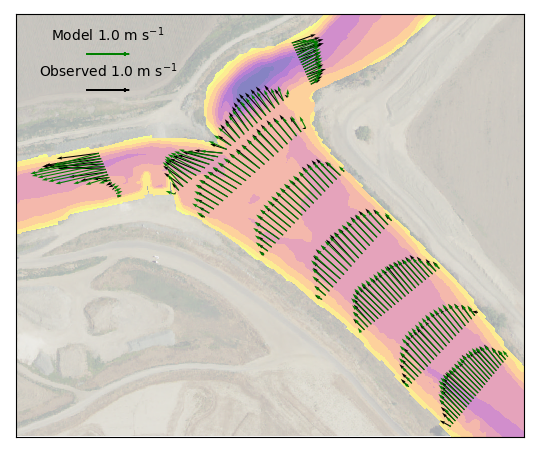

INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=152841.431285, 0 potential interiors


In [44]:
# Quiver plot -- one big plot
fig,ax=plt.subplots(figsize=(5.4,4.5))

colors=['k','g'] # ,'orange','g']
sample_stride=8

for obs_i,avgs in enumerate(all_avgs):
    Qs=[]
    for t,color in zip(avgs,colors):
        t=t.isel(sample=slice(None,None,sample_stride))
        Q=ax.quiver( t.x_sample,t.y_sample, t.Uavg.values[:,0], t.Uavg.values[:,1],
                     color=color, scale_units='xy', scale=0.025,units='xy',angles='xy',
                   width=1.0)
        Qs.append(Q)

ax.quiverkey(Qs[1],0.2,0.88,1.0,'Model 1.0 m s$^{-1}$',coordinates='figure')
ax.quiverkey(Qs[0],0.2,0.8,1.0,'Observed 1.0 m s$^{-1}$',coordinates='figure')

if 0: # gray contoured depth background
    dV=1.0
    demc.contourf(np.arange(-6,6,dV),
                  ax=ax,
                  cmap=light_gray,
                  extend='both',
                  zorder=-2)
    demc.contour(np.arange(-10,6,dV),ax=ax,
                 cmap='gray_r',linewidths=0.2,
                 zorder=-1)
if 1: # faded aerial
    aerial.plot(ax=ax,alpha=0.4,zorder=-2)
    
ax.axis('equal')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
fig.subplots_adjust(left=0.03,right=0.97,top=0.97,bottom=0.03)

zoom=(647018., 647494, 4185602., 4185997.)
ax.axis(zoom)

g=models[0].grid

if 0: 
    offset=4
    g.plot_cells(values='depth',ax=ax,cmap='plasma',zorder=-1,clim=[-8-offset,4-offset])
    
import stompy.plot.cmap as scmap
six.moves.reload_module(scmap)
from matplotlib import cm

fade_plasma=scmap.transform_color(lambda rgb: 0.5*rgb+0.5, cm.plasma)
if 1:
    poly=g.boundary_polygon()
    pnts=np.array(poly.exterior)
    from matplotlib.path import Path
    p=Path(pnts)
    if 0: # regular color-mapped bathy:
        img=demc.plot(ax=ax,zorder=-1,cmap=fade_plasma,clim=[-8,4])
        img.set_clip_path(p,transform=ax.transData)
    if 0: # hillshaded bathy
        img=demc.plot(ax=ax,zorder=-1,cmap='gray',clim=[-30,4])
        img_hs=demc.plot_hillshade(ax=ax,plot_args=dict(zorder=-0.5),z_factor=1.)
        for i in [img,img_hs]:
            i.set_clip_path(p,transform=ax.transData)
    if 0: # contour colored bathy as image
        c=scmap.cmap_discretize(fade_plasma,8)
        img=demc.plot(ax=ax,zorder=-1,cmap=c,clim=[-8,4])
        img.set_clip_path(p,transform=ax.transData)
    if 1:
        mask=demc.polygon_mask(poly)
        mask_demc=demc.copy()
        mask_demc.F[~mask]=np.nan
        mask_demc.contourf(np.linspace(-8,4,8),cmap=fade_plasma,ax=ax,zorder=-1,
                          extend='both')

fig.savefig(os.path.join(fig_dir,'quiver_combined-compare-top2m-20200801.png'),dpi=200)

Velocity overview figure
==

Moved to separate notebook.

Check ADCP against gauge flows
---

Conclusion: River Surveyor reports flow 0.914 * Mossdale gauge, and
`xr_transect` flows are 0.918 * Mossdale gauge.

Even though xr_transect doesn't count the near-shore regions, they
are narrow, shallow, and slow in this dataset. The python results
are ever so slightly better (one less outlier) than the River Surveyor
data.

In [ ]:
# Load MSD flows
import common
six.moves.reload_module(common)
msd_flow=common.msd_flow(np.datetime64('2018-03-10'),
                         np.datetime64('2018-04-20'))

In [ ]:
Qs=[]
Qrivs=[]
times=[]

for tran in obs_trans:
    Q=xr_transect.Qleft(tran)
    Qr=tran.Qmean.item()
    t=tran.time.values
    if tran.label==obs_trans[-1].label:
        # but transects 8 and 9 downstream of the junction on either 
        # side.
        Qs[-1]+=Q
        Qrivs[-1]+=Qr
    else:
        Qs.append(Q)
        Qrivs.append(Qr)
        times.append(t)

In [ ]:
xr_ratio=np.mean( Qs/Q_at_transect)
riv_ratio=np.mean( Qrivs/Q_at_transect )
xr_to_riv_ratio= np.mean( np.array(Qs)/Qrivs)

fig=plt.figure()
plt.plot(times,Qs,'o',label='py=%.3f * Riv=%.3f gauge'%(xr_to_riv_ratio,xr_ratio))
plt.plot(times,Qrivs,'o',label='Riv=%.3f gauge'%(riv_ratio))

plt.plot(msd_flow.time, # -np.timedelta64(1,'h'),
         msd_flow.flow_m3s,'k-',label='Mossdale Gauge')
plt.legend()
plt.axis((736784.946, 736793.951, 166., 324.))

Q_at_transect = np.interp( times, msd_flow.time, msd_flow.flow_m3s) 
fig.autofmt_xdate()


Compare vertical profiles mid-channel
==


In [ ]:
class FigUProf(FigU):
    """
    Figure comparing vertical profiles of along-channel velocity
    """
    labels=None
    hint_lines=False
    
    def __init__(self,obs_tran,**kw):
        self.obs_tran=obs_tran
        utils.set_keywords(self,kw)
        self.fig=self.fig_uprof()
        
    def plot_uprof(self,tran,ax,sample_sel):
        tranu=tran.sel(roz='downstream',sample=sample_sel)
        
        profile=tranu.isel(sample=0)
        z=xr_transect.pos_up(profile,'z_ctr').values
        
        tran_avg=xr_transect.resample_z(tranu,new_z=z,new_z_positive='up')
        u_avg=tran_avg.Uroz.mean(dim='sample')        
        lines=ax.plot(u_avg,z,lw=2.5)
        color=lines[0].get_color()

        if self.hint_lines:
            for si,s in enumerate(sample_sel):
                profile=tranu.isel(sample=si)
                z=xr_transect.pos_up(profile,'z_ctr')
                ax.plot(profile.Uroz, z, lw=0.3, alpha=0.3, color=color)
        
        return lines[0]

    def fig_uprof(self):
        obs_tran=smooth_adcp(self.obs_tran)
        mod_trans=[extract_to_match_obs(obs_tran,model,preserve_angle=True)
                   for model in models]
        all_trans=[obs_tran]+mod_trans

        n_samp=obs_tran.dims['sample']
        sample_sel=np.arange( int(0.45*n_samp), int(0.55*n_samp) )
        
        fig=plt.figure()
        ax=fig.add_subplot(1,1,1)

        # goofy logic to allow appending extra models without worrying about
        # adjusting names passed in.
        labels=self.labels
        if labels is None:
            labels=[]
        for i,t in enumerate(all_trans):
            if i>=len(labels):
                labels.append(t.attrs.get('label',str(i)))

        lines=[]
        for tran in all_trans:
            line=self.plot_uprof(tran,ax,sample_sel)
            lines.append(line)
        ax.set_ylabel('z (m)')
        ax.legend(lines,labels)
        return fig
for obs_tran in obs_trans:
    FigUProf(obs_tran)